In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import random
import math

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")
print("Random seeds set to 42 for reproducibility")

Libraries loaded successfully
Random seeds set to 42 for reproducibility


In [106]:
# Configuration - Same as LSTM notebook
STOCK_SYMBOL = "TSLA"  # Change to analyze different stocks
TARGET_COL = 'Close'
TEST_SIZE = 0.2
RANDOM_SEED = 42

print(f"Configuration:")
print(f"Stock Symbol: {STOCK_SYMBOL}")
print(f"Target Column: {TARGET_COL}")
print(f"Test Size: {TEST_SIZE}")
print(f"Random Seed: {RANDOM_SEED}")
print(f"=" * 60)

Configuration:
Stock Symbol: TSLA
Target Column: Close
Test Size: 0.2
Random Seed: 42


In [107]:
# Load and prepare data - Same as LSTM notebook
print("IMPORTING PREPROCESSED STOCK PRICE + SENTIMENT DATA")
print("=" * 60)

try:
    stock_data_full = pd.read_csv('stock_price_with_sentiment.csv')
    stock_data_full['Date'] = pd.to_datetime(stock_data_full['Date'])
    print(f"Successfully loaded combined dataset: {stock_data_full.shape}")
    
    # Display dataset info
    print(f"Date range: {stock_data_full['Date'].min()} to {stock_data_full['Date'].max()}")
    print(f"Available tickers: {sorted(stock_data_full['ticker'].unique())}")
    print(f"Total records: {len(stock_data_full):,}")
    
    # Display available columns
    print(f"\nAvailable columns ({len(stock_data_full.columns)}):")
    for i, col in enumerate(stock_data_full.columns, 1):
        print(f"   {i:2d}. {col}")
    
    # Filter for the configured stock
    print(f"\nFiltering data for: {STOCK_SYMBOL}")
    
    if STOCK_SYMBOL in stock_data_full['ticker'].unique():
        stock_data = stock_data_full[stock_data_full['ticker'] == STOCK_SYMBOL].copy()
        stock_data = stock_data.sort_values('Date').reset_index(drop=True)
        
        print(f"Successfully filtered for {STOCK_SYMBOL}")
        print(f"Records for {STOCK_SYMBOL}: {len(stock_data):,}")
        print(f"Date range: {stock_data['Date'].min()} to {stock_data['Date'].max()}")
        
        # Display sample data
        print(f"\nSample data for {STOCK_SYMBOL}:")
        sample_cols = ['Date', 'Close', 'sentiment_7d_avg']
        available_sample_cols = [col for col in sample_cols if col in stock_data.columns]
        print(stock_data[available_sample_cols].head(10).to_string(index=False))
        
    else:
        print(f"ERROR: {STOCK_SYMBOL} not found in dataset!")
        print(f"Available tickers: {sorted(stock_data_full['ticker'].unique())}")
        raise ValueError(f"Stock {STOCK_SYMBOL} not available in dataset")
    
except FileNotFoundError:
    print("ERROR: stock_price_with_sentiment.csv not found!")
    print("Please run create_stock_price_with_sentiment.ipynb first to generate the combined dataset.")
    raise

print(f"\nDATASET READY FOR {STOCK_SYMBOL}")
print(f"Data loaded and filtered successfully")
print(f"Shape: {stock_data.shape}")
print(f"Ready for model training!")

IMPORTING PREPROCESSED STOCK PRICE + SENTIMENT DATA
Successfully loaded combined dataset: (20330, 26)
Date range: 2021-05-21 00:00:00 to 2025-06-20 00:00:00
Available tickers: ['AAPL', 'AMZN', 'AVGO', 'BRK.B', 'COST', 'GOOG', 'JNJ', 'JPM', 'LLY', 'MA', 'META', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PG', 'TSLA', 'V', 'WMT', 'XOM']
Total records: 20,330

Available columns (26):
    1. ticker
    2. Date
    3. Open
    4. High
    5. Low
    6. Close
    7. Volume
    8. MA_3
    9. MA_7
   10. MA_10
   11. RSI
   12. MACD
   13. daily_sentiment_score
   14. sentiment_3d_avg
   15. sentiment_7d_avg
   16. sentiment_10d_avg
   17. sentiment_lag_1d
   18. sentiment_lag_3d
   19. sentiment_std
   20. sentiment_volatility_3d
   21. sentiment_volatility_7d
   22. news_volume
   23. news_volume_3d_avg
   24. news_volume_7d_avg
   25. daily_sentiment_category
   26. stock_id

Filtering data for: TSLA
Successfully filtered for TSLA
Records for TSLA: 1,015
Date range: 2021-05-21 00:00:00 to 2025-06-20 

In [108]:
# FEATURE ANALYSIS AND BASELINE MODEL TRAINING - Following LSTM approach
print("FEATURE ANALYSIS AND BASELINE MODEL TRAINING")
print("=" * 60)

# Reset random seeds for reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Helper function for time series prediction (avoiding data leakage)
def create_features_target_timeseries(data, features_list, target_col='Close'):
    """Create features and target for time series prediction - no data leakage"""
    X, y = [], []
    
    for i in range(len(data) - 1):
        # Features from day i
        features = data[features_list].iloc[i].values
        # Target from day i+1
        target = data[target_col].iloc[i+1]
        
        # Only include if no NaN values
        if not np.isnan(features).any() and not np.isnan(target):
            X.append(features)
            y.append(target)
    
    return np.array(X), np.array(y)

# Helper function for model evaluation
def evaluate_tree_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics"""
    predictions = model.predict(X_test)
    
    rmse = math.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    return {
        'model_name': model_name,
        'predictions': predictions,
        'actual': y_test,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

# Helper function for time series split
def time_series_split(X, y, test_size=0.2):
    """Split time series data maintaining temporal order"""
    n_samples = len(X)
    split_idx = int(n_samples * (1 - test_size))
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    return X_train, X_test, y_train, y_test

# IDENTIFY BEST SENTIMENT FEATURE FOR EACH MODEL - Test both RF and XGBoost
print("\nIdentifying best sentiment feature for each model...")
base_features = ['Open', 'High', 'Low', 'Close', 'Volume']

# Test different sentiment features
sentiment_features = ['sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg']
model_sentiment_results = {
    'RandomForest': {},
    'XGBoost': {}
}

print("\nTesting sentiment features for both RandomForest and XGBoost...")

for model_type in ['RandomForest', 'XGBoost']:
    print(f"\n{model_type} sentiment feature analysis:")
    print("-" * 40)
    
    for sentiment_feature in sentiment_features:
        if sentiment_feature in stock_data.columns:
            print(f"  Testing {sentiment_feature}...")
            
            # Create sequences with sentiment feature
            features_with_sentiment = base_features + [sentiment_feature]
            X_sent, y_sent = create_features_target_timeseries(stock_data, features_with_sentiment)
            
            # Use consistent train/test split (no shuffling for time series)
            X_train, X_test, y_train, y_test = time_series_split(X_sent, y_sent, TEST_SIZE)
            
            # Train model based on type
            if model_type == 'RandomForest':
                model = RandomForestRegressor(n_estimators=50, random_state=RANDOM_SEED)
            else:  # XGBoost
                model = XGBRegressor(n_estimators=50, random_state=RANDOM_SEED)
            
            model.fit(X_train, y_train)
            
            # Evaluate
            results = evaluate_tree_model(model, X_test, y_test, f"{model_type}_{sentiment_feature}")
            model_sentiment_results[model_type][sentiment_feature] = results
            
            print(f"    {sentiment_feature}: RMSE ${results['rmse']:.2f}")

# Find best sentiment feature for each model
best_sentiment_features = {}
for model_type in ['RandomForest', 'XGBoost']:
    best_sentiment_feature = min(model_sentiment_results[model_type].keys(), 
                                key=lambda x: model_sentiment_results[model_type][x]['rmse'])
    best_sentiment_features[model_type] = best_sentiment_feature
    
    print(f"\nBest sentiment feature for {model_type}: {best_sentiment_feature}")
    print(f"  RMSE: ${model_sentiment_results[model_type][best_sentiment_feature]['rmse']:.2f}")

# PREPARE FINAL DATASETS FOR COMPARISON
print(f"\nPreparing final datasets for comparison...")

# Dataset 1: OCHLV only (baseline)
baseline_features = base_features
X_baseline, y_baseline = create_features_target_timeseries(stock_data, baseline_features)

# Dataset 2: OCHLV + best sentiment for RandomForest
rf_best_features = base_features + [best_sentiment_features['RandomForest']]
X_rf_best, y_rf_best = create_features_target_timeseries(stock_data, rf_best_features)

# Dataset 3: OCHLV + best sentiment for XGBoost
xgb_best_features = base_features + [best_sentiment_features['XGBoost']]
X_xgb_best, y_xgb_best = create_features_target_timeseries(stock_data, xgb_best_features)

# Use consistent train/test split for all datasets
X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = time_series_split(X_baseline, y_baseline, TEST_SIZE)
X_rf_train, X_rf_test, y_rf_train, y_rf_test = time_series_split(X_rf_best, y_rf_best, TEST_SIZE)
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = time_series_split(X_xgb_best, y_xgb_best, TEST_SIZE)

print(f"Training samples: {len(X_baseline_train)}")
print(f"Test samples: {len(X_baseline_test)}")
print(f"Baseline features: {baseline_features}")
print(f"RandomForest best features: {rf_best_features}")
print(f"XGBoost best features: {xgb_best_features}")

# Summary of sentiment feature selection
print(f"\nSENTIMENT FEATURE SELECTION SUMMARY:")
print("=" * 50)
for model_type in ['RandomForest', 'XGBoost']:
    best_feature = best_sentiment_features[model_type]
    best_rmse = model_sentiment_results[model_type][best_feature]['rmse']
    print(f"{model_type}:")
    print(f"  Best sentiment feature: {best_feature}")
    print(f"  RMSE with best feature: ${best_rmse:.2f}")
    
    # Show all sentiment results for this model
    print(f"  All sentiment features tested:")
    for feature in sentiment_features:
        if feature in model_sentiment_results[model_type]:
            rmse = model_sentiment_results[model_type][feature]['rmse']
            indicator = " ← BEST" if feature == best_feature else ""
            print(f"    {feature}: ${rmse:.2f}{indicator}")
    print()

# Store for later use
globals().update({
    'baseline_features': baseline_features,
    'rf_best_features': rf_best_features,
    'xgb_best_features': xgb_best_features,
    'best_sentiment_features': best_sentiment_features,
    'X_baseline_train': X_baseline_train,
    'X_baseline_test': X_baseline_test,
    'y_baseline_train': y_baseline_train,
    'y_baseline_test': y_baseline_test,
    'X_rf_train': X_rf_train,
    'X_rf_test': X_rf_test,
    'y_rf_train': y_rf_train,
    'y_rf_test': y_rf_test,
    'X_xgb_train': X_xgb_train,
    'X_xgb_test': X_xgb_test,
    'y_xgb_train': y_xgb_train,
    'y_xgb_test': y_xgb_test
})

FEATURE ANALYSIS AND BASELINE MODEL TRAINING

Identifying best sentiment feature for each model...

Testing sentiment features for both RandomForest and XGBoost...

RandomForest sentiment feature analysis:
----------------------------------------
  Testing sentiment_3d_avg...
    sentiment_3d_avg: RMSE $18.45
  Testing sentiment_7d_avg...
    sentiment_7d_avg: RMSE $19.91
  Testing sentiment_10d_avg...
    sentiment_10d_avg: RMSE $18.88

XGBoost sentiment feature analysis:
----------------------------------------
  Testing sentiment_3d_avg...
    sentiment_3d_avg: RMSE $19.68
  Testing sentiment_7d_avg...
    sentiment_7d_avg: RMSE $22.72
  Testing sentiment_10d_avg...
    sentiment_10d_avg: RMSE $20.71

Best sentiment feature for RandomForest: sentiment_3d_avg
  RMSE: $18.45

Best sentiment feature for XGBoost: sentiment_3d_avg
  RMSE: $19.68

Preparing final datasets for comparison...
Training samples: 811
Test samples: 203
Baseline features: ['Open', 'High', 'Low', 'Close', 'Volume'

In [109]:
# BASELINE MODEL TRAINING - Following LSTM structure
print("RF BASELINE MODEL TRAINING")
print("=" * 60)

# Reset random seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Training RF baseline OCHLV model...")

# Build baseline model
baseline_model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Train baseline model
baseline_model.fit(X_baseline_train, y_baseline_train)

# Evaluate baseline model
baseline_results = evaluate_tree_model(
    baseline_model, X_baseline_test, y_baseline_test, "Baseline OCHLV Model"
)

print(f"\nRF Baseline Model Performance:")
print(f"  RMSE: ${baseline_results['rmse']:.2f}")
print(f"  MAE:  ${baseline_results['mae']:.2f}")
print(f"  R²:   {baseline_results['r2']:.4f}")
print(f"  MAPE: {baseline_results['mape']:.2f}%")

print(f"\nRF Baseline model training completed!")

# BASELINE MODEL TRAINING - Following LSTM structure
print("XGB BASELINE MODEL TRAINING")
print("=" * 60)

print("Training XGB baseline OCHLV model...")

# Build baseline model
baseline_model = XGBRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Train baseline model
baseline_model.fit(X_baseline_train, y_baseline_train)

# Evaluate baseline model
baseline_results = evaluate_tree_model(
    baseline_model, X_baseline_test, y_baseline_test, "Baseline OCHLV Model"
)

print(f"\nBaseline XGB Model Performance:")
print(f"  RMSE: ${baseline_results['rmse']:.2f}")
print(f"  MAE:  ${baseline_results['mae']:.2f}")
print(f"  R²:   {baseline_results['r2']:.4f}")
print(f"  MAPE: {baseline_results['mape']:.2f}%")

print(f"\nRF Baseline XGB model training completed!")

RF BASELINE MODEL TRAINING
Training RF baseline OCHLV model...

RF Baseline Model Performance:
  RMSE: $17.90
  MAE:  $12.77
  R²:   0.9313
  MAPE: 4.03%

RF Baseline model training completed!
XGB BASELINE MODEL TRAINING
Training XGB baseline OCHLV model...

Baseline XGB Model Performance:
  RMSE: $18.78
  MAE:  $13.80
  R²:   0.9244
  MAPE: 4.37%

RF Baseline XGB model training completed!


In [110]:
# HYPERPARAMETER OPTIMIZATION - Following LSTM approach
print("HYPERPARAMETER OPTIMIZATION")
print("=" * 60)

# For tree models, we'll do a simpler grid search instead of Optuna
# since tree models have fewer hyperparameters and are faster to train

from sklearn.model_selection import TimeSeriesSplit
import time

print("Preparing data for hyperparameter optimization...")

# Use same split as LSTM for consistency
n_samples = len(X_xgb_best)
test_size = int(TEST_SIZE * n_samples)
train_val_size = n_samples - test_size

# Split off test set (same as LSTM)
X_xgb_train_val = X_xgb_best[:train_val_size]
y_xgb_train_val = y_xgb_best[:train_val_size]
X_xgb_test_final = X_xgb_best[train_val_size:]
y_xgb_test_final = y_xgb_best[train_val_size:]

X_rf_train_val = X_rf_best[:train_val_size]
y_rf_train_val = y_rf_best[:train_val_size]
X_rf_test_final = X_rf_best[train_val_size:]
y_rf_test_final = y_rf_best[train_val_size:]

print(f"Train+Val samples: {train_val_size}")
print(f"Test samples: {test_size}")

# Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=3)

# Grid search parameters
param_grid = {
    'RandomForest': [
        {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2},
        {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5},
        {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10},
        {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
    ],
    'XGBoost': [
        {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1},
        {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.05},
        {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}
    ]
}

print(f"\nStarting hyperparameter optimization...")
print(f"Number of parameter combinations: {len(param_grid['RandomForest']) + len(param_grid['XGBoost'])}")
print(f"Cross-validation folds: 3")

start_time = time.time()

best_params = {}
best_scores = {}

for model_type in ['RandomForest', 'XGBoost']:
    print(f"\nOptimizing {model_type}...")
    best_score = float('inf')
    best_param = None
    
    for trial_num, params in enumerate(param_grid[model_type]):
        print(f"  Trial {trial_num + 1}: {params}")
        
        # Cross-validation scores
        cv_scores = []
        
        # Perform time series cross-validation
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X_xgb_train_val)):
            
            # Get fold data
            X_train_fold = X_xgb_train_val[train_idx]
            X_val_fold = X_xgb_train_val[val_idx]
            y_train_fold = y_xgb_train_val[train_idx]
            y_val_fold = y_xgb_train_val[val_idx]
            
            try:
                # Build model
                if model_type == 'RandomForest':
                    model = RandomForestRegressor(random_state=RANDOM_SEED, **params)
                else:  # XGBoost
                    model = XGBRegressor(random_state=RANDOM_SEED, **params)
                
                # Train model
                model.fit(X_train_fold, y_train_fold)
                
                # Evaluate on validation fold
                predictions = model.predict(X_val_fold)
                fold_rmse = math.sqrt(mean_squared_error(y_val_fold, predictions))
                cv_scores.append(fold_rmse)
                
                print(f"    Fold {fold + 1}: RMSE = ${fold_rmse:.2f}")
                
            except Exception as e:
                print(f"    Fold {fold + 1} failed: {str(e)}")
                cv_scores.append(float('inf'))
        
        # Calculate average CV score
        avg_cv_score = np.mean(cv_scores)
        std_cv_score = np.std(cv_scores)
        
        print(f"    Trial {trial_num + 1} CV Average: ${avg_cv_score:.2f} ± ${std_cv_score:.2f}")
        
        if avg_cv_score < best_score:
            best_score = avg_cv_score
            best_param = params
    
    best_params[model_type] = best_param
    best_scores[model_type] = best_score
    
    print(f"  Best {model_type} params: {best_param}")
    print(f"  Best {model_type} CV RMSE: ${best_score:.2f}")

end_time = time.time()
duration = (end_time - start_time) / 60

print(f"\nHyperparameter optimization completed!")
print(f"Total time: {duration:.1f} minutes")

# Choose overall best model
if best_scores['RandomForest'] < best_scores['XGBoost']:
    best_model_type = 'RandomForest'
    best_cv_rmse = best_scores['RandomForest']
    best_model_params = best_params['RandomForest']
else:
    best_model_type = 'XGBoost'
    best_cv_rmse = best_scores['XGBoost']
    best_model_params = best_params['XGBoost']

print(f"\nBest overall model: {best_model_type}")
print(f"Best hyperparameters: {best_model_params}")
print(f"Best cross-validation RMSE: ${best_cv_rmse:.2f}")

# Store results
globals().update({
    'best_model_type': best_model_type,
    'best_model_params': best_model_params,
    'best_cv_rmse': best_cv_rmse
})

HYPERPARAMETER OPTIMIZATION
Preparing data for hyperparameter optimization...
Train+Val samples: 812
Test samples: 202

Starting hyperparameter optimization...
Number of parameter combinations: 8
Cross-validation folds: 3

Optimizing RandomForest...
  Trial 1: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 2}
    Fold 1: RMSE = $20.74
    Fold 2: RMSE = $9.25
    Fold 3: RMSE = $7.99
    Trial 1 CV Average: $12.66 ± $5.74
  Trial 2: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 5}
    Fold 1: RMSE = $20.48
    Fold 2: RMSE = $9.04
    Fold 3: RMSE = $7.86
    Trial 2 CV Average: $12.46 ± $5.69
  Trial 3: {'n_estimators': 150, 'max_depth': 20, 'min_samples_split': 10}
    Fold 1: RMSE = $20.69
    Fold 2: RMSE = $10.14
    Fold 3: RMSE = $7.78
    Trial 3 CV Average: $12.87 ± $5.61
  Trial 4: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}
    Fold 1: RMSE = $20.70
    Fold 2: RMSE = $9.15
    Fold 3: RMSE = $7.92
    Trial 4 CV Average: $12.59

In [111]:
# TRAIN OPTIMIZED MODELS AND FINAL EVALUATION - Both RF and XGBoost
print("TRAIN OPTIMIZED MODELS AND FINAL EVALUATION")
print("=" * 60)

# Reset random seed
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print("Preparing data for final training...")
print(f"Training data: {X_rf_train_val.shape}")
print(f"Test data: {X_rf_test_final.shape}")

# TRAIN BOTH RANDOMFOREST AND XGBOOST MODELS
print("\nBuilding and training both optimized models...")

# Build and train RandomForest model
print(f"\nRandomForest hyperparameters:")
for key, value in best_params['RandomForest'].items():
    print(f"  {key}: {value}")

rf_model = RandomForestRegressor(random_state=RANDOM_SEED, **best_params['RandomForest'])
print("Training RandomForest model...")
rf_model.fit(X_rf_train_val, y_rf_train_val)

# Build and train XGBoost model  
print(f"\nXGBoost hyperparameters:")
for key, value in best_params['XGBoost'].items():
    print(f"  {key}: {value}")

xgb_model = XGBRegressor(random_state=RANDOM_SEED, **best_params['XGBoost'])
print("Training XGBoost model...")
xgb_model.fit(X_xgb_train_val, y_xgb_train_val)

# EVALUATE BOTH MODELS ON TEST SET
print(f"\nEvaluating both models on test set...")

# Evaluate RandomForest model
rf_results = evaluate_tree_model(
    rf_model, X_rf_test_final, y_rf_test_final, "Optimized RandomForest with Sentiment"
)

# Evaluate XGBoost model
xgb_results = evaluate_tree_model(
    xgb_model, X_xgb_test_final, y_xgb_test_final, "Optimized XGBoost with Sentiment"
)

# BASELINE MODEL - Evaluate on same test set for fair comparison
print(f"\nEvaluating baseline model on same test set...")

# Re-create baseline data with same split as optimized models
X_baseline_full, y_baseline_full = create_features_target_timeseries(stock_data, baseline_features)

# Use the same indices as the optimized models
n_samples_baseline = len(X_baseline_full)
test_size_baseline = int(TEST_SIZE * n_samples_baseline)
train_val_size_baseline = n_samples_baseline - test_size_baseline

X_baseline_train_final = X_baseline_full[:train_val_size_baseline]
X_baseline_test_final = X_baseline_full[train_val_size_baseline:]
y_baseline_train_final = y_baseline_full[:train_val_size_baseline]
y_baseline_test_final = y_baseline_full[train_val_size_baseline:]

# Retrain baseline model on the same training set size
baseline_model_final = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
baseline_model_final.fit(X_baseline_train_final, y_baseline_train_final)

# Evaluate baseline on the same test set
baseline_test_results = evaluate_tree_model(
    baseline_model_final, X_baseline_test_final, y_baseline_test_final, "Baseline OCHLV Model"
)

print(f"Baseline test samples: {len(baseline_test_results['predictions'])}")
print(f"RandomForest test samples: {len(rf_results['predictions'])}")
print(f"XGBoost test samples: {len(xgb_results['predictions'])}")

# Ensure all have the same length for plotting
min_length = min(len(baseline_test_results['predictions']), 
                 len(rf_results['predictions']), 
                 len(xgb_results['predictions']))

if (len(baseline_test_results['predictions']) != min_length or
    len(rf_results['predictions']) != min_length or
    len(xgb_results['predictions']) != min_length):
    print(f"Adjusting all arrays to common length: {min_length}")
    
    # Trim all to same length
    for results in [baseline_test_results, rf_results, xgb_results]:
        for key in ['predictions', 'actual']:
            if key in results:
                results[key] = results[key][:min_length]

# COMPARISON RESULTS
print(f"\nFINAL COMPARISON RESULTS")
print("=" * 60)

print(f"Baseline OCHLV Model:")
print(f"  Features: {baseline_features}")
print(f"  RMSE: ${baseline_test_results['rmse']:.2f}")
print(f"  MAE:  ${baseline_test_results['mae']:.2f}")
print(f"  R²:   {baseline_test_results['r2']:.4f}")
print(f"  MAPE: {baseline_test_results['mape']:.2f}%")

print(f"\nOptimized RandomForest with Sentiment:")
print(f"  Features: {rf_best_features}")
print(f"  Cross-validation RMSE: ${best_scores['RandomForest']:.2f}")
print(f"  Test RMSE: ${rf_results['rmse']:.2f}")
print(f"  Test MAE:  ${rf_results['mae']:.2f}")
print(f"  Test R²:   {rf_results['r2']:.4f}")
print(f"  Test MAPE: {rf_results['mape']:.2f}%")

print(f"\nOptimized XGBoost with Sentiment:")
print(f"  Features: {xgb_best_features}")
print(f"  Cross-validation RMSE: ${best_scores['XGBoost']:.2f}")
print(f"  Test RMSE: ${xgb_results['rmse']:.2f}")
print(f"  Test MAE:  ${xgb_results['mae']:.2f}")
print(f"  Test R²:   {xgb_results['r2']:.4f}")
print(f"  Test MAPE: {xgb_results['mape']:.2f}%")

# Calculate improvements for both models
rf_rmse_improvement = ((baseline_test_results['rmse'] - rf_results['rmse']) / baseline_test_results['rmse']) * 100
rf_mae_improvement = ((baseline_test_results['mae'] - rf_results['mae']) / baseline_test_results['mae']) * 100
rf_r2_improvement = ((rf_results['r2'] - baseline_test_results['r2']) / abs(baseline_test_results['r2'])) * 100

xgb_rmse_improvement = ((baseline_test_results['rmse'] - xgb_results['rmse']) / baseline_test_results['rmse']) * 100
xgb_mae_improvement = ((baseline_test_results['mae'] - xgb_results['mae']) / baseline_test_results['mae']) * 100
xgb_r2_improvement = ((xgb_results['r2'] - baseline_test_results['r2']) / abs(baseline_test_results['r2'])) * 100

print(f"\nRandomForest Improvement with Sentiment + Optimization:")
print(f"  RMSE: {rf_rmse_improvement:+.2f}% {'(Better)' if rf_rmse_improvement > 0 else '(Worse)'}")
print(f"  MAE:  {rf_mae_improvement:+.2f}% {'(Better)' if rf_mae_improvement > 0 else '(Worse)'}")
print(f"  R²:   {rf_r2_improvement:+.2f}% {'(Better)' if rf_r2_improvement > 0 else '(Worse)'}")

print(f"\nXGBoost Improvement with Sentiment + Optimization:")
print(f"  RMSE: {xgb_rmse_improvement:+.2f}% {'(Better)' if xgb_rmse_improvement > 0 else '(Worse)'}")
print(f"  MAE:  {xgb_mae_improvement:+.2f}% {'(Better)' if xgb_mae_improvement > 0 else '(Worse)'}")
print(f"  R²:   {xgb_r2_improvement:+.2f}% {'(Better)' if xgb_r2_improvement > 0 else '(Worse)'}")

# Consistency checks for both models
rf_cv_test_diff = abs(best_scores['RandomForest'] - rf_results['rmse'])
rf_consistency_percent = (1 - rf_cv_test_diff / best_scores['RandomForest']) * 100

xgb_cv_test_diff = abs(best_scores['XGBoost'] - xgb_results['rmse'])
xgb_consistency_percent = (1 - xgb_cv_test_diff / best_scores['XGBoost']) * 100

print(f"\nRandomForest Consistency Check:")
print(f"  CV-Test RMSE difference: ${rf_cv_test_diff:.2f}")
print(f"  Consistency: {rf_consistency_percent:.1f}%")

print(f"\nXGBoost Consistency Check:")
print(f"  CV-Test RMSE difference: ${xgb_cv_test_diff:.2f}")
print(f"  Consistency: {xgb_consistency_percent:.1f}%")

# Determine overall best model
if rf_results['rmse'] < xgb_results['rmse']:
    best_model_name = "RandomForest"
    best_model_results = rf_results
    best_improvement = rf_rmse_improvement
    best_consistency = rf_consistency_percent
else:
    best_model_name = "XGBoost"
    best_model_results = xgb_results
    best_improvement = xgb_rmse_improvement
    best_consistency = xgb_consistency_percent

print(f"\nOverall Best Model: {best_model_name}")
print(f"  Best RMSE: ${best_model_results['rmse']:.2f}")
print(f"  Best improvement: {best_improvement:+.2f}%")

# Store results for plotting
final_comparison_results = {
    'baseline': baseline_test_results,
    'rf': rf_results,
    'xgb': xgb_results,
    'rf_improvement': rf_rmse_improvement,
    'xgb_improvement': xgb_rmse_improvement,
    'rf_consistency': rf_consistency_percent,
    'xgb_consistency': xgb_consistency_percent,
    'best_model': best_model_name
}

print(f"\nModel training and evaluation completed!")
print(f"Best sentiment feature: {best_sentiment_feature}")
print(f"All models trained: Baseline, RandomForest, XGBoost")
print(f"All models use identical test sets for fair comparison.")

# Store both models for later use
globals().update({
    'rf_model': rf_model,
    'xgb_model': xgb_model,
    'rf_results': rf_results,
    'xgb_results': xgb_results,
    'best_model_name': best_model_name,
    'best_model_results': best_model_results,
    'final_comparison_results': final_comparison_results
})

TRAIN OPTIMIZED MODELS AND FINAL EVALUATION
Preparing data for final training...
Training data: (812, 6)
Test data: (202, 6)

Building and training both optimized models...

RandomForest hyperparameters:
  n_estimators: 100
  max_depth: 15
  min_samples_split: 5
Training RandomForest model...

XGBoost hyperparameters:
  n_estimators: 50
  max_depth: 3
  learning_rate: 0.1
Training XGBoost model...

Evaluating both models on test set...

Evaluating baseline model on same test set...
Baseline test samples: 202
RandomForest test samples: 202
XGBoost test samples: 202

FINAL COMPARISON RESULTS
Baseline OCHLV Model:
  Features: ['Open', 'High', 'Low', 'Close', 'Volume']
  RMSE: $17.99
  MAE:  $12.85
  R²:   0.9301
  MAPE: 4.04%

Optimized RandomForest with Sentiment:
  Features: ['Open', 'High', 'Low', 'Close', 'Volume', 'sentiment_3d_avg']
  Cross-validation RMSE: $12.46
  Test RMSE: $18.41
  Test MAE:  $12.98
  Test R²:   0.9269
  Test MAPE: 4.06%

Optimized XGBoost with Sentiment:
  Feat

COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS
Created directory: tree_models_analysis_plots_20250709_215810
Creating Plot 1: Price Predictions Comparison...


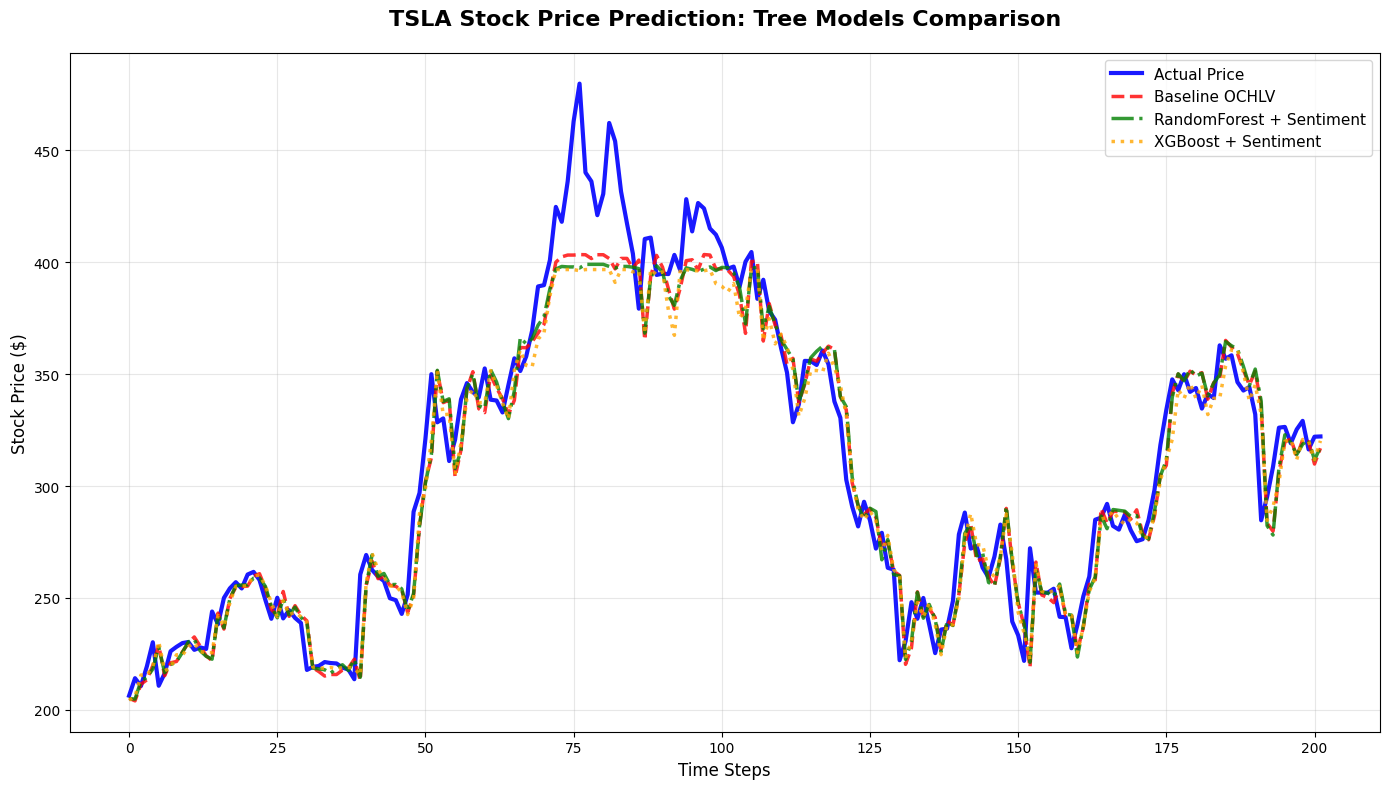

Creating Plot 2: Performance Metrics Comparison...


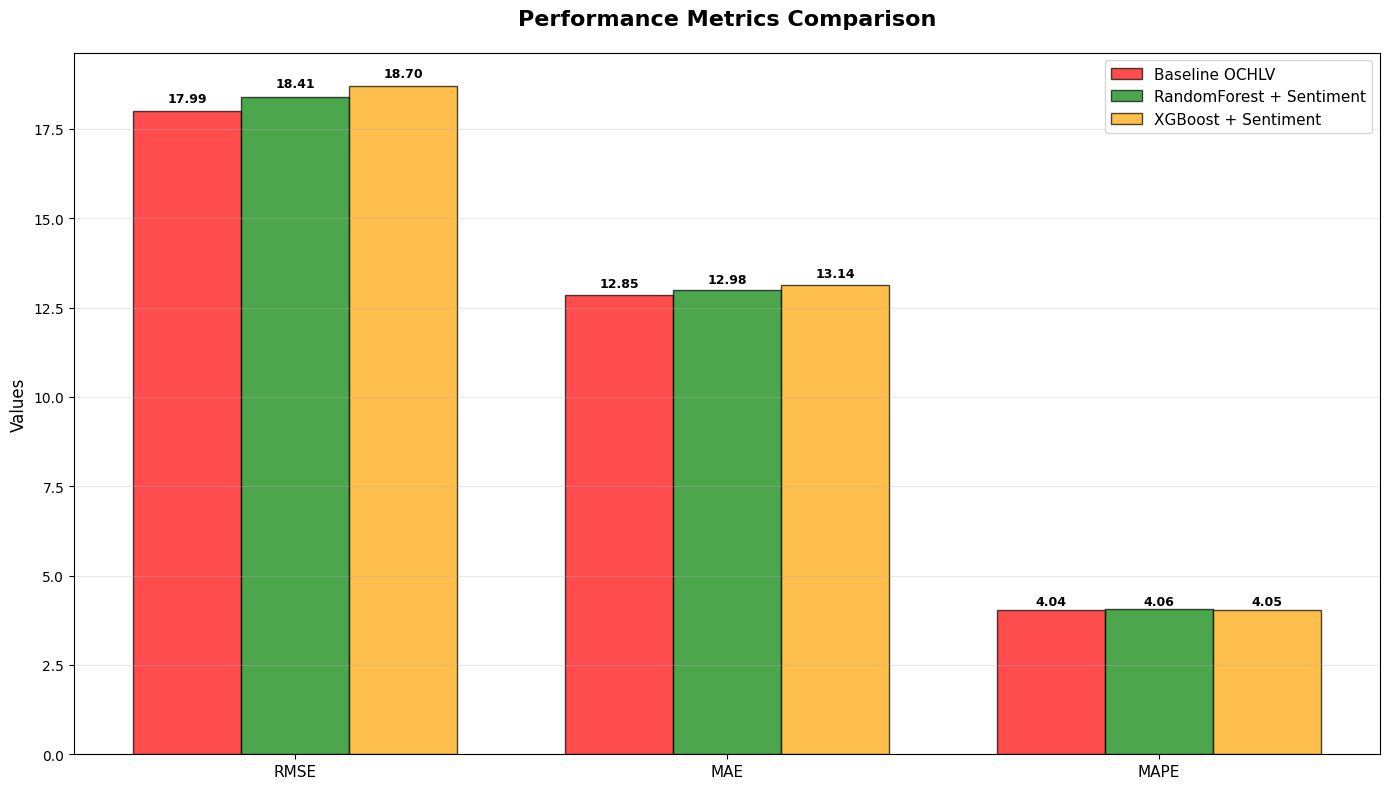

Creating Plot 3: R² Score Comparison...


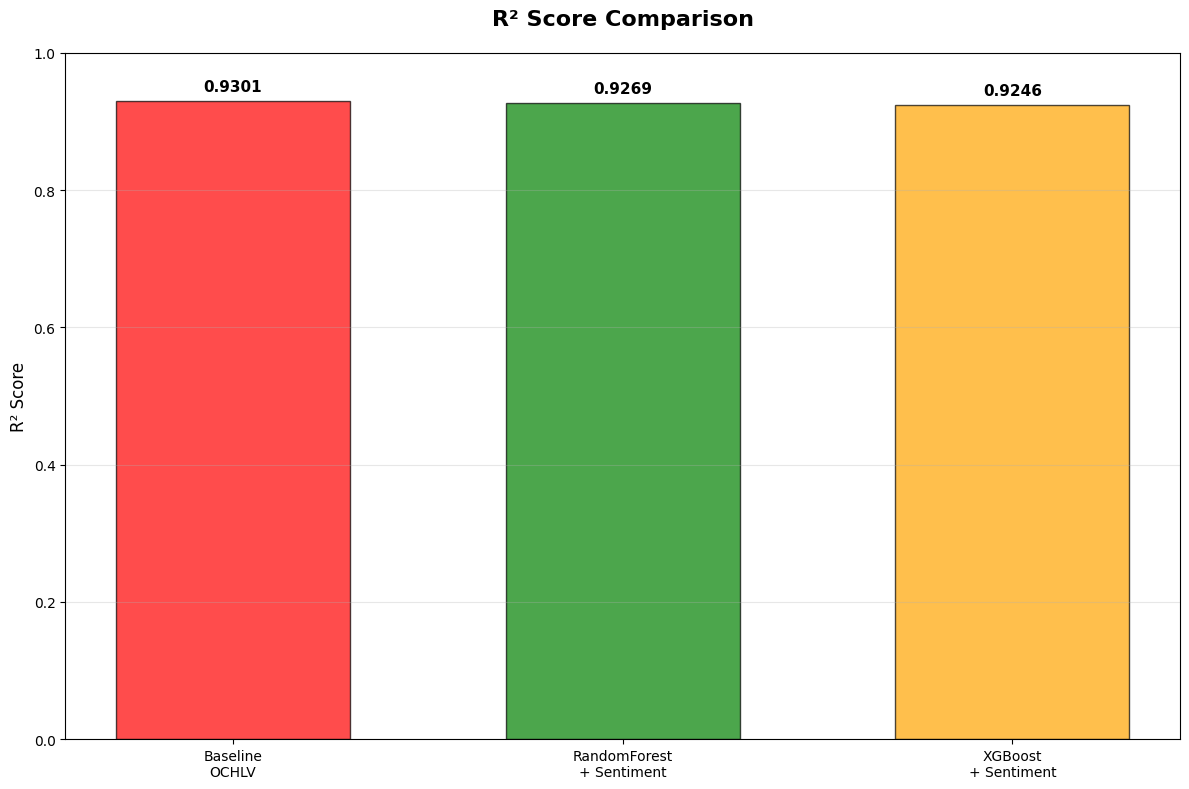

Creating Plot 4: Prediction Errors Over Time...


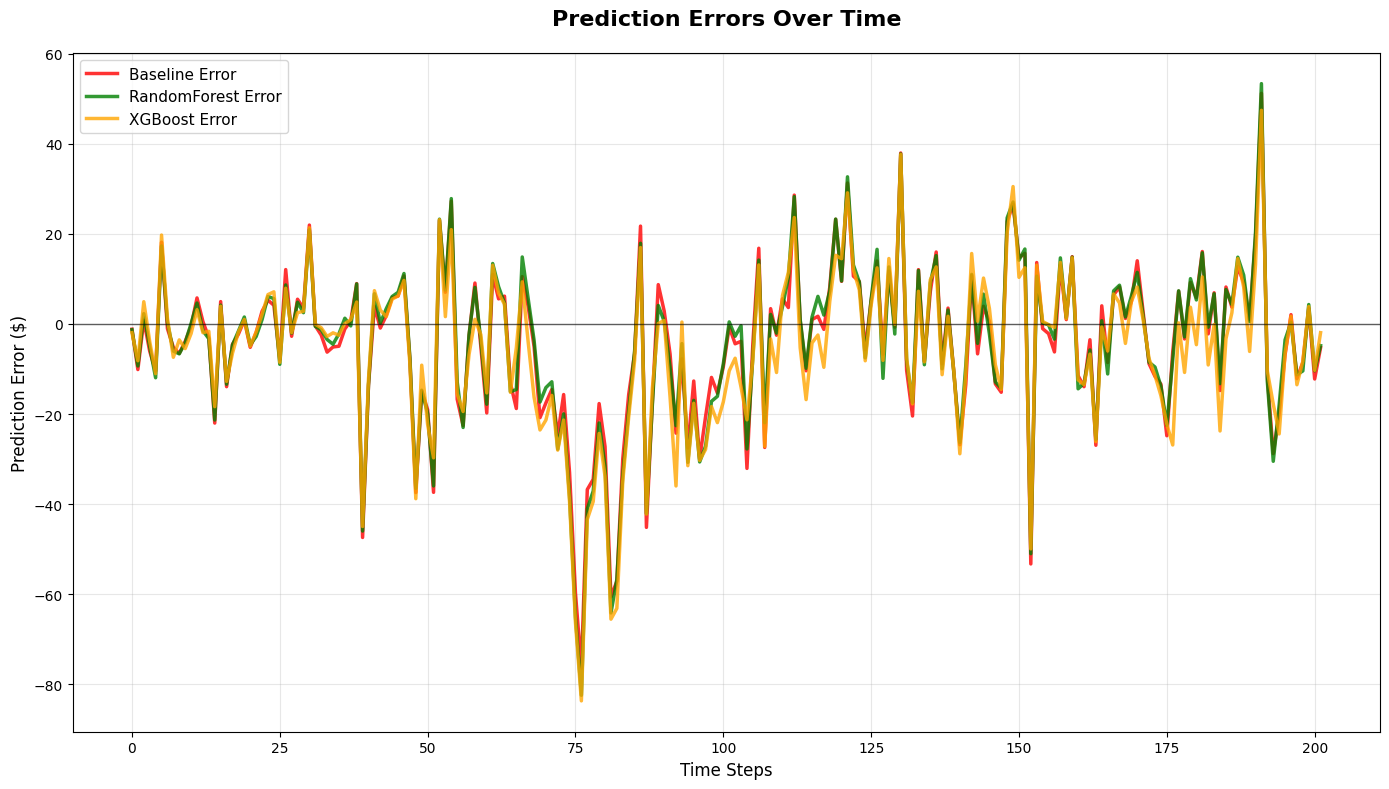

Creating Plot 5: Error Distribution...


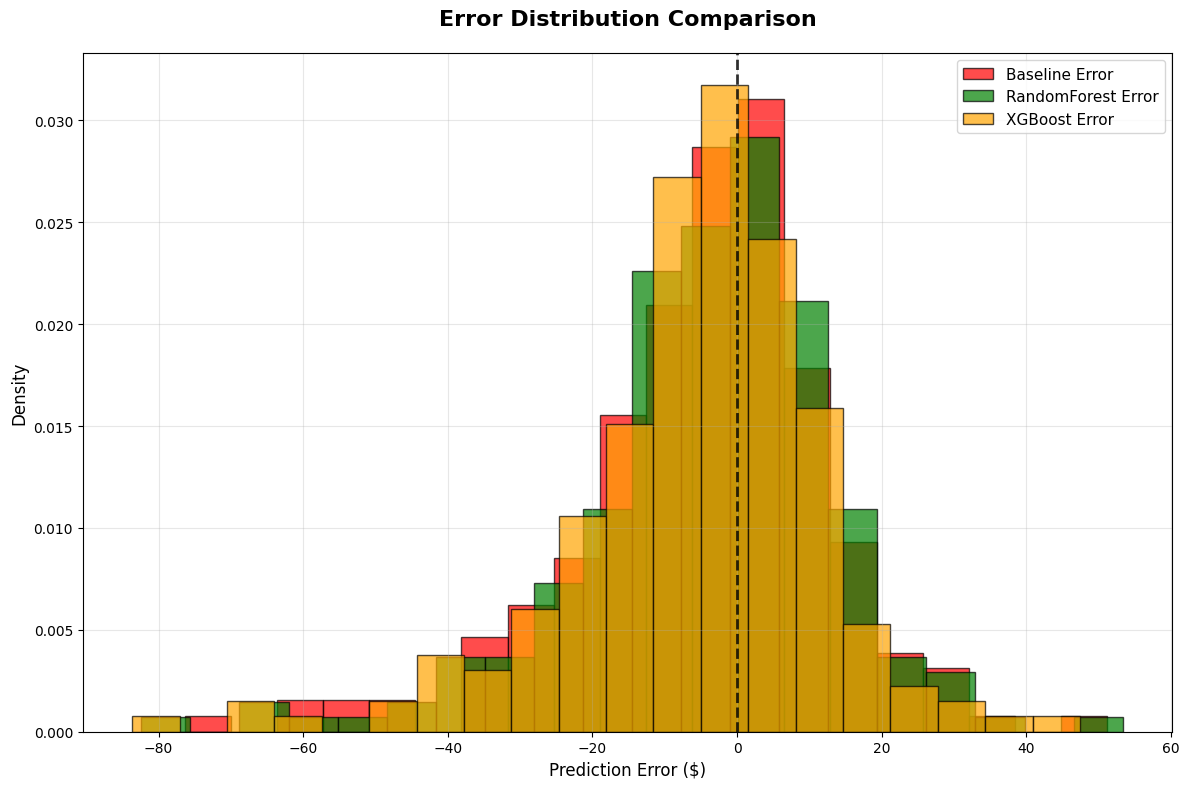

Creating Plot 6: Model Summary...


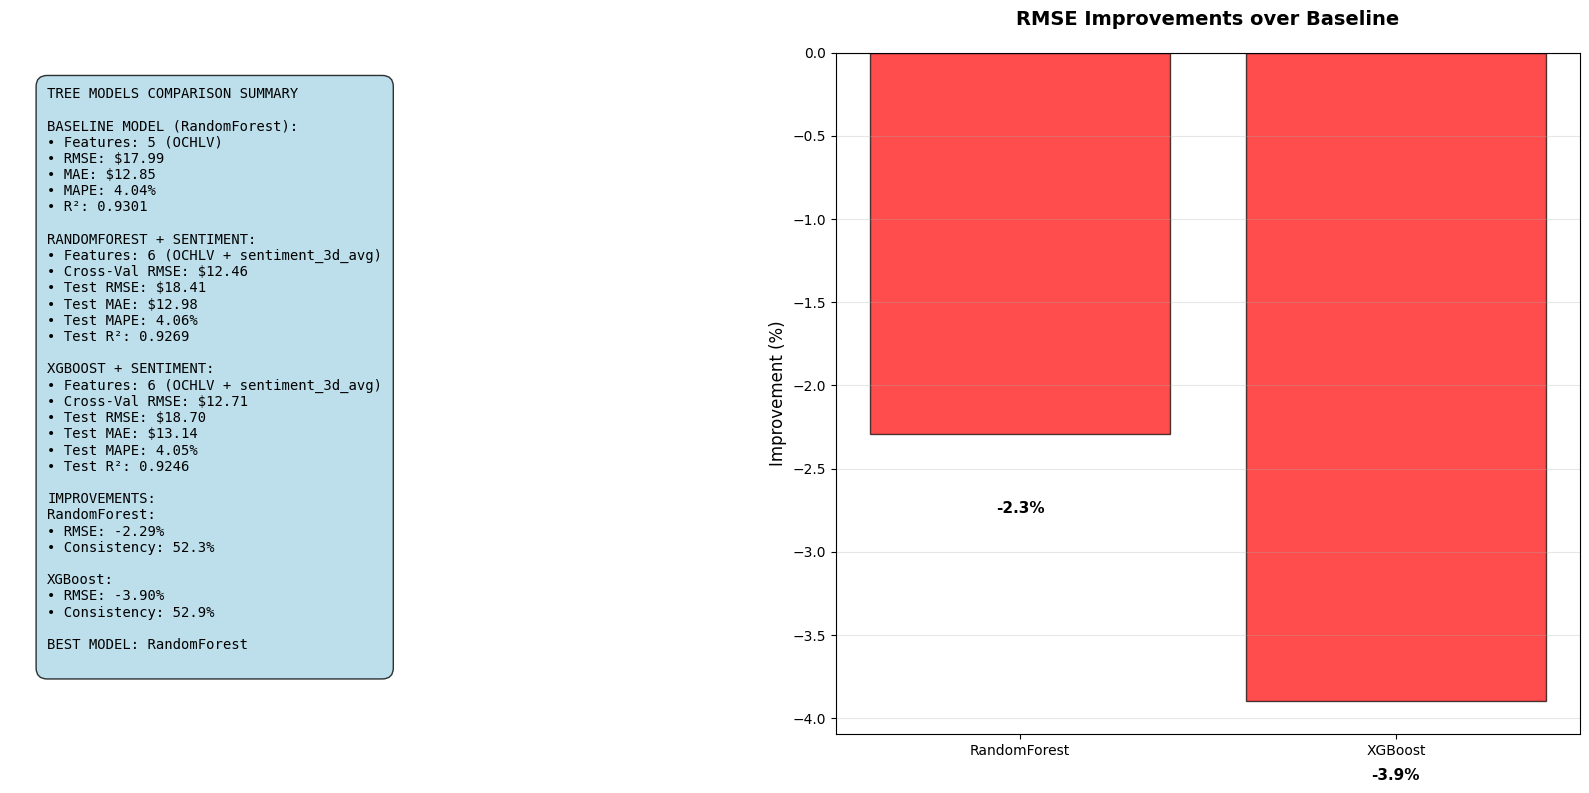

Creating Plot 7: Stock Price vs Sentiment Time Series...


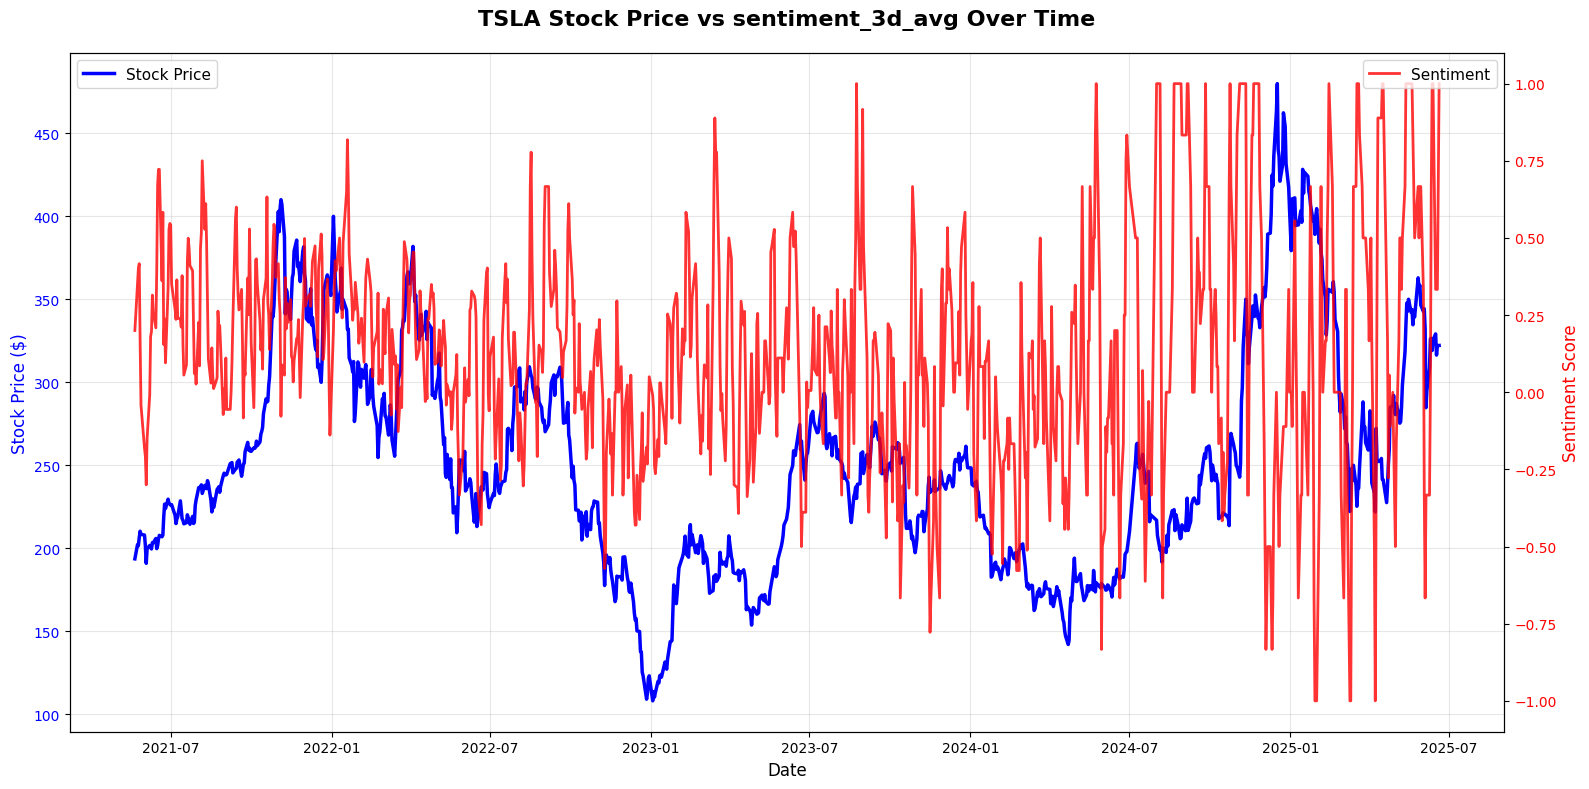

Creating Plot 8: Price vs Sentiment Scatter Plot...


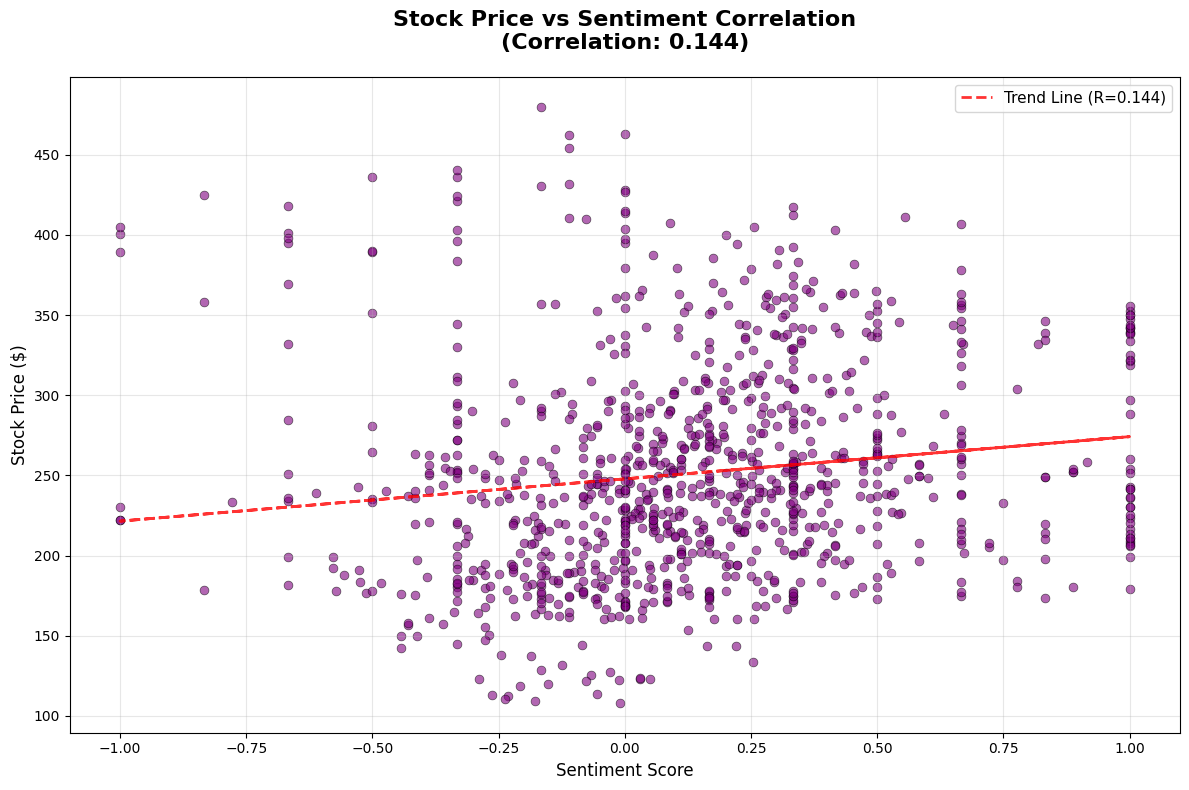

Creating Plot 9: Sentiment Feature Selection Results...


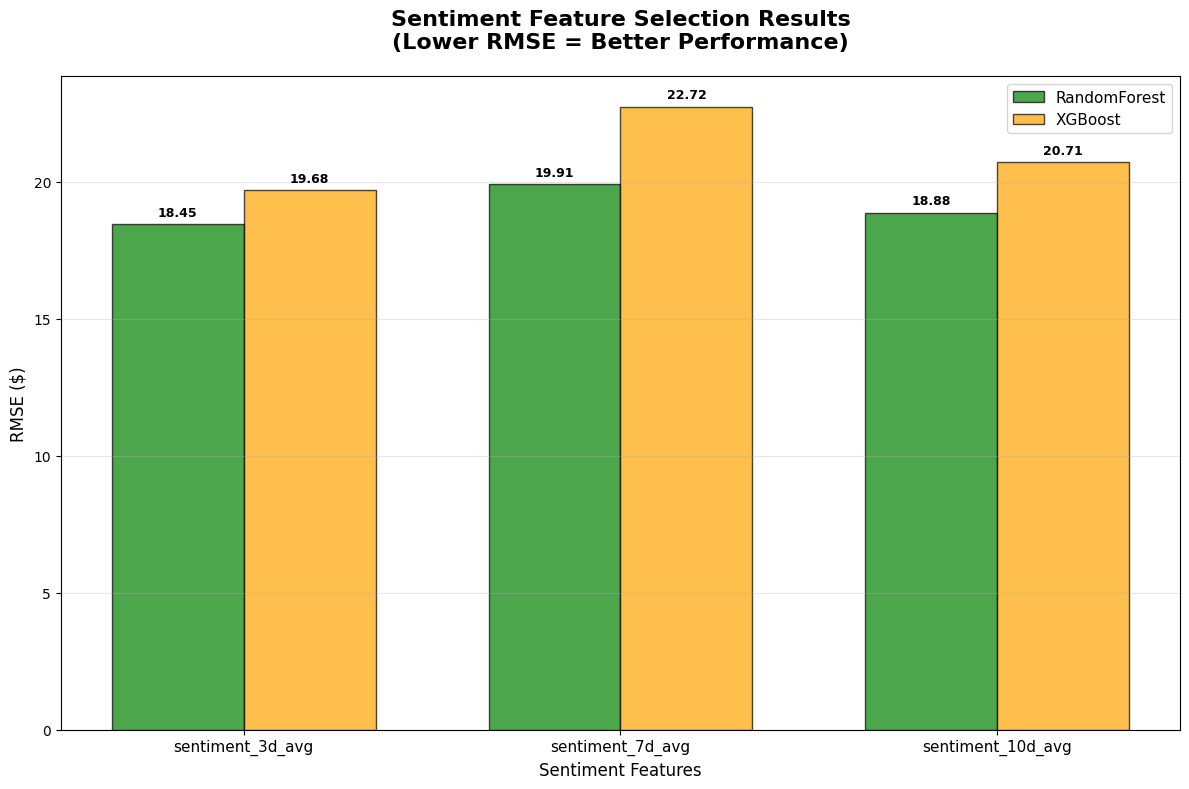

Creating Plot 10: Feature Importance Analysis...


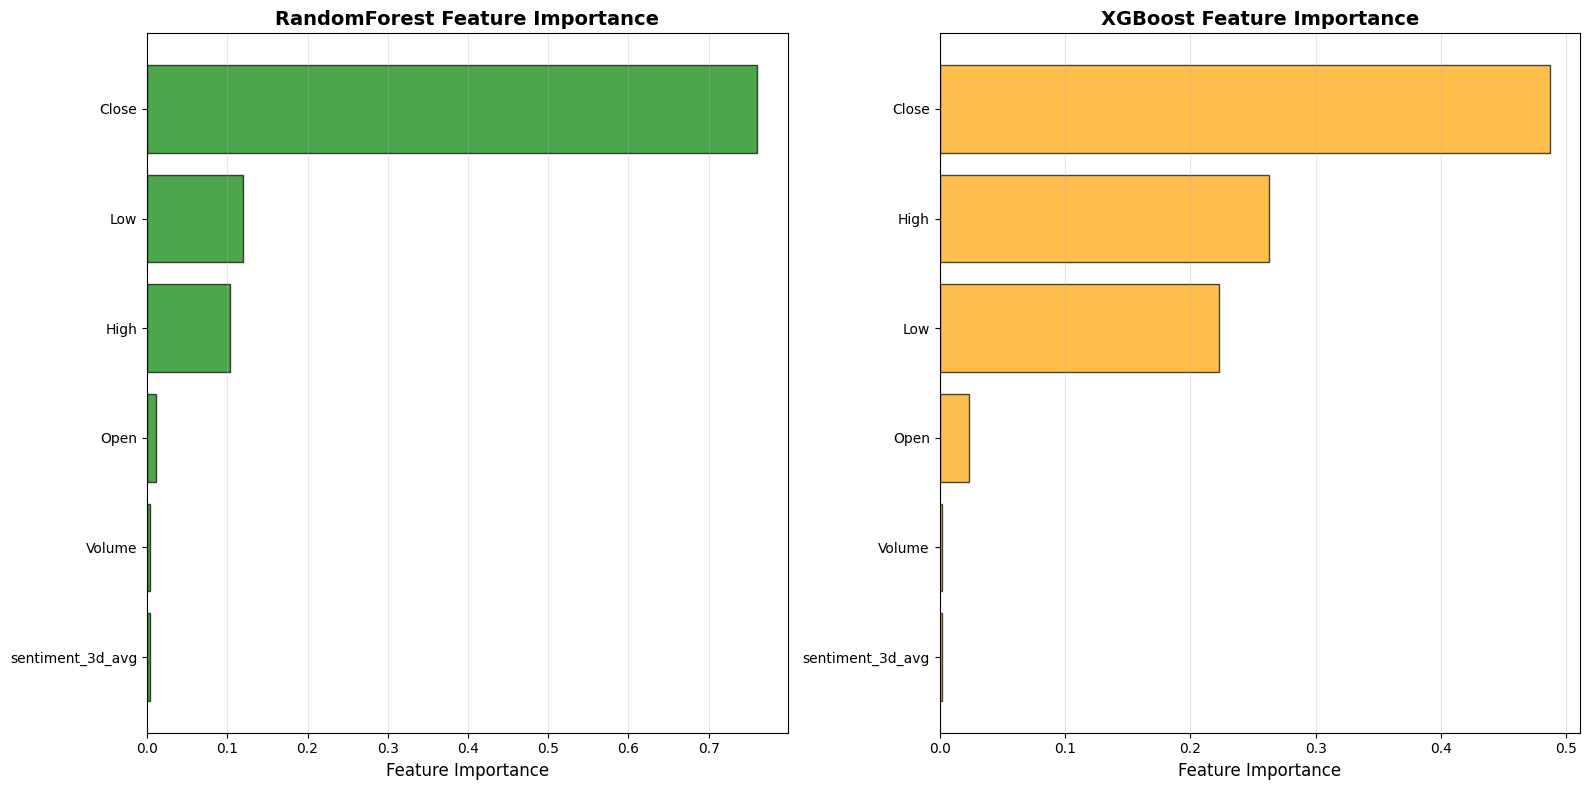


SUMMARY STATISTICS
Dataset: TSLA
Date range: 2021-05-21 to 2025-06-20
Total samples: 1015
Training samples: 811
Test samples: 203

Sentiment feature selection:
RandomForest best: sentiment_3d_avg
XGBoost best: sentiment_3d_avg

Correlation analysis:
  sentiment_3d_avg vs price: 0.1436

Final performance:
  Baseline RMSE: $17.99
  RandomForest RMSE: $18.41 (-2.29%)
  XGBoost RMSE: $18.70 (-3.90%)

Best model: RandomForest

Plots saved to: tree_models_analysis_plots_20250709_215810/
  01_price_predictions_comparison.png
  02_performance_metrics.png
  03_r2_comparison.png
  04_prediction_errors.png
  05_error_distribution.png
  06_model_summary.png
  07_price_sentiment_timeseries.png
  08_price_sentiment_scatter.png
  09_sentiment_feature_selection.png
  10_feature_importance.png

Tree models analysis completed with LSTM-style visualizations!


In [112]:
# =============================================================================
# COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS
# =============================================================================

print("COMPREHENSIVE VISUALIZATION AND ANALYSIS - INDIVIDUAL PLOTS")
print("=" * 60)

import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime

# Create directory for saving plots
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plot_dir = f"tree_models_analysis_plots_{timestamp}"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    print(f"Created directory: {plot_dir}")

# Extract values from the stored results
baseline_rmse = final_comparison_results['baseline']['rmse']
baseline_mae = final_comparison_results['baseline']['mae']
baseline_r2 = final_comparison_results['baseline']['r2']
baseline_mape = final_comparison_results['baseline']['mape']
baseline_pred = final_comparison_results['baseline']['predictions']

rf_rmse = final_comparison_results['rf']['rmse']
rf_mae = final_comparison_results['rf']['mae']
rf_r2 = final_comparison_results['rf']['r2']
rf_mape = final_comparison_results['rf']['mape']
rf_pred = final_comparison_results['rf']['predictions']

xgb_rmse = final_comparison_results['xgb']['rmse']
xgb_mae = final_comparison_results['xgb']['mae']
xgb_r2 = final_comparison_results['xgb']['r2']
xgb_mape = final_comparison_results['xgb']['mape']
xgb_pred = final_comparison_results['xgb']['predictions']

# Get actual test values (they should be the same for all models)
y_test_actual = final_comparison_results['rf']['actual']

# =============================================================================
# INDIVIDUAL PLOT 1: Price Predictions Comparison
# =============================================================================

print("Creating Plot 1: Price Predictions Comparison...")

plt.figure(figsize=(14, 8))
time_steps = range(len(y_test_actual))

plt.plot(time_steps, y_test_actual, 
         label='Actual Price', color='blue', linewidth=3, alpha=0.9)
plt.plot(time_steps, baseline_pred, 
         label='Baseline OCHLV', color='red', linewidth=2.5, alpha=0.8, linestyle='--')
plt.plot(time_steps, rf_pred, 
         label='RandomForest + Sentiment', color='green', linewidth=2.5, alpha=0.8, linestyle='-.')
plt.plot(time_steps, xgb_pred, 
         label='XGBoost + Sentiment', color='orange', linewidth=2.5, alpha=0.8, linestyle=':')

plt.title(f'{STOCK_SYMBOL} Stock Price Prediction: Tree Models Comparison', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/01_price_predictions_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 2: Performance Metrics Comparison
# =============================================================================

print("Creating Plot 2: Performance Metrics Comparison...")

plt.figure(figsize=(14, 8))

metrics = ['RMSE', 'MAE', 'MAPE']
baseline_vals = [baseline_rmse, baseline_mae, baseline_mape]
rf_vals = [rf_rmse, rf_mae, rf_mape]
xgb_vals = [xgb_rmse, xgb_mae, xgb_mape]

x = np.arange(len(metrics))
width = 0.25

bars1 = plt.bar(x - width, baseline_vals, width, label='Baseline OCHLV', 
                color='red', alpha=0.7, edgecolor='black')
bars2 = plt.bar(x, rf_vals, width, label='RandomForest + Sentiment', 
                color='green', alpha=0.7, edgecolor='black')
bars3 = plt.bar(x + width, xgb_vals, width, label='XGBoost + Sentiment', 
                color='orange', alpha=0.7, edgecolor='black')

plt.title('Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Values', fontsize=12)
plt.xticks(x, metrics, fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(f"{plot_dir}/02_performance_metrics.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 3: R² Score Comparison
# =============================================================================

print("Creating Plot 3: R² Score Comparison...")

plt.figure(figsize=(12, 8))

r2_values = [baseline_r2, rf_r2, xgb_r2]
model_names = ['Baseline\nOCHLV', 'RandomForest\n+ Sentiment', 'XGBoost\n+ Sentiment']
colors = ['red', 'green', 'orange']

bars = plt.bar(model_names, r2_values, color=colors, alpha=0.7, edgecolor='black', width=0.6)
plt.title('R² Score Comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('R² Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/03_r2_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 4: Prediction Errors Over Time
# =============================================================================

print("Creating Plot 4: Prediction Errors Over Time...")

plt.figure(figsize=(14, 8))

baseline_errors = baseline_pred - y_test_actual
rf_errors = rf_pred - y_test_actual
xgb_errors = xgb_pred - y_test_actual

plt.plot(time_steps, baseline_errors, 
         label='Baseline Error', color='red', linewidth=2.5, alpha=0.8)
plt.plot(time_steps, rf_errors, 
         label='RandomForest Error', color='green', linewidth=2.5, alpha=0.8)
plt.plot(time_steps, xgb_errors, 
         label='XGBoost Error', color='orange', linewidth=2.5, alpha=0.8)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.6, linewidth=1)

plt.title('Prediction Errors Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Prediction Error ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/04_prediction_errors.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 5: Error Distribution
# =============================================================================

print("Creating Plot 5: Error Distribution...")

plt.figure(figsize=(12, 8))

plt.hist(baseline_errors, bins=20, alpha=0.7, label='Baseline Error', 
         color='red', density=True, edgecolor='black')
plt.hist(rf_errors, bins=20, alpha=0.7, label='RandomForest Error', 
         color='green', density=True, edgecolor='black')
plt.hist(xgb_errors, bins=20, alpha=0.7, label='XGBoost Error', 
         color='orange', density=True, edgecolor='black')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.8, linewidth=2)

plt.title('Error Distribution Comparison', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Prediction Error ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{plot_dir}/05_error_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 6: Model Summary and Performance Improvements
# =============================================================================

print("Creating Plot 6: Model Summary...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left side: Text summary
ax1.axis('off')
summary_text = f"""TREE MODELS COMPARISON SUMMARY

BASELINE MODEL (RandomForest):
• Features: {len(baseline_features)} (OCHLV)
• RMSE: ${baseline_rmse:.2f}
• MAE: ${baseline_mae:.2f}
• MAPE: {baseline_mape:.2f}%
• R²: {baseline_r2:.4f}

RANDOMFOREST + SENTIMENT:
• Features: {len(rf_best_features)} (OCHLV + {best_sentiment_features['RandomForest']})
• Cross-Val RMSE: ${best_scores['RandomForest']:.2f}
• Test RMSE: ${rf_rmse:.2f}
• Test MAE: ${rf_mae:.2f}
• Test MAPE: {rf_mape:.2f}%
• Test R²: {rf_r2:.4f}

XGBOOST + SENTIMENT:
• Features: {len(xgb_best_features)} (OCHLV + {best_sentiment_features['XGBoost']})
• Cross-Val RMSE: ${best_scores['XGBoost']:.2f}
• Test RMSE: ${xgb_rmse:.2f}
• Test MAE: ${xgb_mae:.2f}
• Test MAPE: {xgb_mape:.2f}%
• Test R²: {xgb_r2:.4f}

IMPROVEMENTS:
RandomForest:
• RMSE: {final_comparison_results['rf_improvement']:+.2f}%
• Consistency: {final_comparison_results['rf_consistency']:.1f}%

XGBoost:
• RMSE: {final_comparison_results['xgb_improvement']:+.2f}%
• Consistency: {final_comparison_results['xgb_consistency']:.1f}%

BEST MODEL: {final_comparison_results['best_model']}
"""

ax1.text(0.05, 0.95, summary_text, transform=ax1.transAxes, fontsize=10, 
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.8", facecolor="lightblue", alpha=0.8))

# Right side: Improvement bars
models = ['RandomForest', 'XGBoost']
improvement_vals = [final_comparison_results['rf_improvement'], final_comparison_results['xgb_improvement']]
colors = ['green' if x > 0 else 'red' for x in improvement_vals]

bars = ax2.bar(models, improvement_vals, color=colors, alpha=0.7, edgecolor='black')
ax2.set_title('RMSE Improvements over Baseline', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('Improvement (%)', fontsize=12)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.6)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, value in zip(bars, improvement_vals):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + (0.2 if value > 0 else -0.4),
            f'{value:+.1f}%', ha='center', va='bottom' if value > 0 else 'top', 
            fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/06_model_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 7: Stock Price vs Sentiment Time Series
# =============================================================================

print("Creating Plot 7: Stock Price vs Sentiment Time Series...")

# Get sentiment data
dates = stock_data['Date']
prices = stock_data['Close']
sentiment = stock_data[best_sentiment_features['RandomForest']]

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot stock price
ax1.plot(dates, prices, color='blue', linewidth=2.5, label='Stock Price')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Stock Price ($)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# Plot sentiment on secondary axis
ax2 = ax1.twinx()
ax2.plot(dates, sentiment, color='red', linewidth=2, alpha=0.8, label='Sentiment')
ax2.set_ylabel('Sentiment Score', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title(f'{STOCK_SYMBOL} Stock Price vs {best_sentiment_features["RandomForest"]} Over Time', 
          fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# Add legends
ax1.legend(loc='upper left', fontsize=11)
ax2.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/07_price_sentiment_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 8: Price vs Sentiment Scatter Plot
# =============================================================================

print("Creating Plot 8: Price vs Sentiment Scatter Plot...")

plt.figure(figsize=(12, 8))

correlation = np.corrcoef(sentiment.dropna(), prices[sentiment.notna()])[0, 1]
plt.scatter(sentiment, prices, alpha=0.6, s=40, c='purple', edgecolors='black', linewidth=0.5)
plt.xlabel('Sentiment Score', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.title(f'Stock Price vs Sentiment Correlation\n(Correlation: {correlation:.3f})', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(sentiment.dropna(), prices[sentiment.notna()], 1)
p = np.poly1d(z)
plt.plot(sentiment, p(sentiment), "r--", alpha=0.8, linewidth=2, label=f'Trend Line (R={correlation:.3f})')
plt.legend(fontsize=11)

plt.tight_layout()
plt.savefig(f"{plot_dir}/08_price_sentiment_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 9: Sentiment Feature Selection Results
# =============================================================================

print("Creating Plot 9: Sentiment Feature Selection Results...")

plt.figure(figsize=(12, 8))

# Get sentiment feature results for both models
sentiment_features = ['sentiment_3d_avg', 'sentiment_7d_avg', 'sentiment_10d_avg']
rf_rmse_values = [model_sentiment_results['RandomForest'][feat]['rmse'] for feat in sentiment_features]
xgb_rmse_values = [model_sentiment_results['XGBoost'][feat]['rmse'] for feat in sentiment_features]

x = np.arange(len(sentiment_features))
width = 0.35

bars1 = plt.bar(x - width/2, rf_rmse_values, width, label='RandomForest', 
                color='green', alpha=0.7, edgecolor='black')
bars2 = plt.bar(x + width/2, xgb_rmse_values, width, label='XGBoost', 
                color='orange', alpha=0.7, edgecolor='black')

plt.title('Sentiment Feature Selection Results\n(Lower RMSE = Better Performance)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('RMSE ($)', fontsize=12)
plt.xlabel('Sentiment Features', fontsize=12)
plt.xticks(x, sentiment_features, fontsize=11)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig(f"{plot_dir}/09_sentiment_feature_selection.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# INDIVIDUAL PLOT 10: Feature Importance Analysis
# =============================================================================

print("Creating Plot 10: Feature Importance Analysis...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# RandomForest Feature Importance
rf_feature_importance = pd.DataFrame({
    'feature': rf_best_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

ax1.barh(range(len(rf_feature_importance)), rf_feature_importance['importance'], 
         color='green', alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(rf_feature_importance)))
ax1.set_yticklabels(rf_feature_importance['feature'], fontsize=10)
ax1.set_xlabel('Feature Importance', fontsize=12)
ax1.set_title('RandomForest Feature Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# XGBoost Feature Importance
xgb_feature_importance = pd.DataFrame({
    'feature': xgb_best_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=True)

ax2.barh(range(len(xgb_feature_importance)), xgb_feature_importance['importance'], 
         color='orange', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(xgb_feature_importance)))
ax2.set_yticklabels(xgb_feature_importance['feature'], fontsize=10)
ax2.set_xlabel('Feature Importance', fontsize=12)
ax2.set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f"{plot_dir}/10_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print(f"\nSUMMARY STATISTICS")
print("=" * 50)

print(f"Dataset: {STOCK_SYMBOL}")
print(f"Date range: {dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")
print(f"Total samples: {len(stock_data)}")
print(f"Training samples: {len(X_baseline_train)}")
print(f"Test samples: {len(X_baseline_test)}")

print(f"\nSentiment feature selection:")
print(f"RandomForest best: {best_sentiment_features['RandomForest']}")
print(f"XGBoost best: {best_sentiment_features['XGBoost']}")

print(f"\nCorrelation analysis:")
print(f"  {best_sentiment_features['RandomForest']} vs price: {correlation:.4f}")

print(f"\nFinal performance:")
print(f"  Baseline RMSE: ${baseline_rmse:.2f}")
print(f"  RandomForest RMSE: ${rf_rmse:.2f} ({final_comparison_results['rf_improvement']:+.2f}%)")
print(f"  XGBoost RMSE: ${xgb_rmse:.2f} ({final_comparison_results['xgb_improvement']:+.2f}%)")

print(f"\nBest model: {final_comparison_results['best_model']}")

print(f"\nPlots saved to: {plot_dir}/")
print(f"  01_price_predictions_comparison.png")
print(f"  02_performance_metrics.png")
print(f"  03_r2_comparison.png") 
print(f"  04_prediction_errors.png")
print(f"  05_error_distribution.png")
print(f"  06_model_summary.png")
print(f"  07_price_sentiment_timeseries.png")
print(f"  08_price_sentiment_scatter.png")
print(f"  09_sentiment_feature_selection.png")
print(f"  10_feature_importance.png")

print(f"\nTree models analysis completed with LSTM-style visualizations!")

In [113]:
# Save Results for Future Reference
import os

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Extract values from the stored results for saving
baseline_rmse = final_comparison_results['baseline']['rmse']
baseline_mae = final_comparison_results['baseline']['mae']
baseline_r2 = final_comparison_results['baseline']['r2']
baseline_mape = final_comparison_results['baseline']['mape']

rf_rmse = final_comparison_results['rf']['rmse']
rf_mae = final_comparison_results['rf']['mae']
rf_r2 = final_comparison_results['rf']['r2']
rf_mape = final_comparison_results['rf']['mape']

xgb_rmse = final_comparison_results['xgb']['rmse']
xgb_mae = final_comparison_results['xgb']['mae']
xgb_r2 = final_comparison_results['xgb']['r2']
xgb_mape = final_comparison_results['xgb']['mape']

# Calculate improvements
rf_improvement = final_comparison_results['rf_improvement']
xgb_improvement = final_comparison_results['xgb_improvement']

# Create feature importance dataframes
rf_feature_importance = pd.DataFrame({
    'feature': best_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

xgb_feature_importance = pd.DataFrame({
    'feature': best_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Prepare results dictionary
results = {
    'stock': STOCK_SYMBOL,
    'features': best_features,
    'best_sentiment_feature': best_sentiment_feature,
    'test_samples': len(final_comparison_results['rf']['actual']),
    'models': {
        'baseline': {
            'rmse': baseline_rmse,
            'mae': baseline_mae,
            'r2': baseline_r2,
            'mape': baseline_mape
        },
        'randomforest': {
            'rmse': rf_rmse,
            'mae': rf_mae,
            'r2': rf_r2,
            'mape': rf_mape,
            'improvement': rf_improvement,
            'hyperparameters': best_params['RandomForest'],
            'feature_importance': rf_feature_importance.to_dict('records')
        },
        'xgboost': {
            'rmse': xgb_rmse,
            'mae': xgb_mae,
            'r2': xgb_r2,
            'mape': xgb_mape,
            'improvement': xgb_improvement,
            'hyperparameters': best_params['XGBoost'],
            'feature_importance': xgb_feature_importance.to_dict('records')
        }
    }
}

# Save detailed results
import json
results_file = f'{results_dir}/tree_models_results_{STOCK_SYMBOL.lower()}.json'
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2, default=str)

print(f"Results saved to: {results_file}")

# Create comparison summary for easy reference
comparison_summary = pd.DataFrame({
    'Model': ['Baseline', 'RandomForest', 'XGBoost'],
    'RMSE': [baseline_rmse, rf_rmse, xgb_rmse],
    'MAE': [baseline_mae, rf_mae, xgb_mae],
    'R²': [baseline_r2, rf_r2, xgb_r2],
    'MAPE': [baseline_mape, rf_mape, xgb_mape],
    'RMSE_Improvement': [0, rf_improvement, xgb_improvement]
})

# Save comparison summary
summary_file = f'{results_dir}/tree_models_comparison_{STOCK_SYMBOL.lower()}.csv'
comparison_summary.to_csv(summary_file, index=False)

print(f"Comparison summary saved to: {summary_file}")
print(f"\nExperiment completed successfully!")
print(f"Stock: {STOCK_SYMBOL}")
print(f"Features used: {len(best_features)}")
print(f"Test period: {len(final_comparison_results['rf']['actual'])} days")

# Display final comparison
print(f"\nFINAL COMPARISON:")
print(comparison_summary.round(3))

Results saved to: ../results/tree_models_results_tsla.json
Comparison summary saved to: ../results/tree_models_comparison_tsla.csv

Experiment completed successfully!
Stock: TSLA
Features used: 6
Test period: 202 days

FINAL COMPARISON:
          Model    RMSE     MAE     R²   MAPE  RMSE_Improvement
0      Baseline  17.995  12.852  0.930  4.041             0.000
1  RandomForest  18.407  12.979  0.927  4.056            -2.294
2       XGBoost  18.696  13.136  0.925  4.045            -3.900
